# Homework 2
---

## Project I

### Part 1 - Optimization of Resource Allocation of a Social Network

This problem focuses on optimizing the operations of a social network platform by strategically allocating resources through the deployment of data centers and the efficient routing of user data between these centers and designated user regions through the course of four time periods, quarters. 

* Each data center incurs a fixed setup cost and has a defined maximum capacity for handling requests.

* Energy costs vary based on the data center's location, and they are proportional to the amount of data processed.

* User regions generate specific request loads that must be served in full for each quarter. Each region also has an associated priority level, reflecting its criticality to the platform's operations for the different time periods. 

The objective is to minimize the total operational costs, including the setup costs for activating data centers and the energy costs associated with data routing for each quarter of a year.

The model will therefore determine; which data centers to activate for cost-effective operations and the optimal routing schema to minimize energy costs while ensuring all user regions are satisfied.

In [24]:
# IMPORTS 
from pyomo.environ import *
import pandas as pd

### Data
* **User Regions ($R$)**

A set of 10 user regions, each with a specified request load for each quarter:
$$
R = \{R1, R2, ..., R10\}, 


Q = \{Q1, Q2, Q3, Q4\}
$$

Request Load:
$$
  \text{request\_load}_{i, j} \quad \text{, where } i \in R \text{ and } j \in Q
$$

Criticality:
$$
  C_{i,j} \in \text{(0, 1)} \quad \text{, where } i \in R \text{ and } j \in Q
$$

Where **Criticality** refers to the importance or priority level of each user region in terms of its service requirements in the different quarters. If criticality = 1, it is specially important that the region is provided with high availability and redundancy for that time. These regions must be served by at least 3 distinct data centers.

*  **Potential Data Center Locations ($D$)**
A set of 7 potential locations for data centers, each with a fixed setup cost, maximum capacity ($c_d$), and energy cost per unit of data distributed:

$$
D = \{D1, D2, ..., D7\}
$$

| **Data Center** | **Setup Cost (M€)** | **Capacity (units)** | **Energy Cost (per unit of data)** |
|------------------|---------------------|-----------------------|-----------------------|
| D1              | 2                 | 15                    | 5                    | 
| D2              | 3                 | 20                    | 7                    | 
| D3              | 2                 | 18                    | 6                    |
| D4              | 4                 | 25                    | 8                    |
| D5              | 2                 | 15                    | 5                    | 
| D6              | 3                 | 17                    | 5                    |
| D7              | 3                 | 22                    | 6                    | 




In [25]:
user_regions = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10']
data_centers = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

request_load = {
    ('R1', 'Q1'): 2, ('R2', 'Q1'): 2, ('R3', 'Q1'): 3, ('R4', 'Q1'): 4, ('R5', 'Q1'): 3, ('R6', 'Q1'): 1, 
    ('R7', 'Q1'): 2, ('R8', 'Q1'): 3, ('R9', 'Q1'): 2, ('R10', 'Q1'): 4,
    
    ('R1', 'Q2'): 5, ('R2', 'Q2'): 4, ('R3', 'Q2'): 2, ('R4', 'Q2'): 3, ('R5', 'Q2'): 1, ('R6', 'Q2'): 3, 
    ('R7', 'Q2'): 2, ('R8', 'Q2'): 2, ('R9', 'Q2'): 7, ('R10', 'Q2'): 2,
    
    ('R1', 'Q3'): 2, ('R2', 'Q3'): 3, ('R3', 'Q3'): 4, ('R4', 'Q3'): 4, ('R5', 'Q3'): 3, ('R6', 'Q3'): 7, 
    ('R7', 'Q3'): 3, ('R8', 'Q3'): 1, ('R9', 'Q3'): 5, ('R10', 'Q3'): 2,
    
    ('R1', 'Q4'): 4, ('R2', 'Q4'): 3, ('R3', 'Q4'): 3, ('R4', 'Q4'): 2, ('R5', 'Q4'): 4, ('R6', 'Q4'): 2, 
    ('R7', 'Q4'): 5, ('R8', 'Q4'): 3, ('R9', 'Q4'): 2, ('R10', 'Q4'): 6
}

criticality = {
    ('R1', 'Q1'): 0, ('R2', 'Q1'): 0, ('R3', 'Q1'): 1, ('R4', 'Q1'): 1, ('R5', 'Q1'): 0, 
    ('R6', 'Q1'): 1, ('R7', 'Q1'): 0, ('R8', 'Q1'): 1, ('R9', 'Q1'): 1, ('R10', 'Q1'): 0,
    
    ('R1', 'Q2'): 1, ('R2', 'Q2'): 0, ('R3', 'Q2'): 0, ('R4', 'Q2'): 1, ('R5', 'Q2'): 0, 
    ('R6', 'Q2'): 1, ('R7', 'Q2'): 0, ('R8', 'Q2'): 1, ('R9', 'Q2'): 1, ('R10', 'Q2'): 0,
    
    ('R1', 'Q3'): 0, ('R2', 'Q3'): 1, ('R3', 'Q3'): 0, ('R4', 'Q3'): 1, ('R5', 'Q3'): 0, 
    ('R6', 'Q3'): 1, ('R7', 'Q3'): 0, ('R8', 'Q3'): 1, ('R9', 'Q3'): 1, ('R10', 'Q3'): 0,
    
    ('R1', 'Q4'): 0, ('R2', 'Q4'): 0, ('R3', 'Q4'): 1, ('R4', 'Q4'): 1, ('R5', 'Q4'): 0, 
    ('R6', 'Q4'): 1, ('R7', 'Q4'): 1, ('R8', 'Q4'): 0, ('R9', 'Q4'): 1, ('R10', 'Q4'): 0
}

setup_cost = {'D1': 2, 'D2': 3, 'D3': 2, 'D4': 4, 'D5': 2, 'D6': 3, 'D7': 3}
capacity = {'D1': 11, 'D2': 15, 'D3': 13, 'D4': 15, 'D5': 11, 'D6': 9, 'D7': 12}

energy_cost = {'D1': 5, 'D2': 7, 'D3': 6, 'D4': 8, 'D5': 5, 'D6': 5, 'D7': 6} 

In [26]:
#### MODEL ####
model = ConcreteModel()

#### SETS ####
model.D = Set(initialize=data_centers, doc = "Set of Data Center Locations")
model.R = Set(initialize=user_regions, doc = "Set of User Regions")
model.Q = Set(initialize = quarters, doc = 'Set of Quarters, time frame')

#### PARAMETERS ####
model.request_load = Param(model.R, model.Q, initialize=request_load, doc="Load requested by each region for each quarter")
model.criticality = Param(model.R, model.Q, initialize=criticality, doc="Criticality of each region for each quarter")
model.setup_cost = Param(model.D, initialize=setup_cost, doc="Setup cost for each data center")
model.capacity = Param(model.D, initialize=capacity, doc="Capacity of each data center")
model.energy_cost = Param(model.D, initialize=energy_cost, doc="Energy cost of each data center")


---

### Decision Variables

1. **Data Center Deployment ($y_{dq}$):**  
   Binary variable indicating if a data center is deployed at location $d$ in time $q$:  
   $$
   y_{dq} =
   \begin{cases} 
   1 & \text{if data center } d \text{ is deployed } \text{ in time } q, \\ 
   0 & \text{otherwise.}
   \end{cases}
   $$

2. **Data Routing ($x_{rdq}$):**  
   Represents the amount of data transferred from a specific data center $d$ to a specific user region $r$ in time $q$.

3. **Data Routing ($z_{rdq}$):**  
   Indicates whether or not data is being routed from a specific data center $d$ to a specific user region $r$ in time $q$.
   $$
   z_{rdq} =
   \begin{cases} 
   1 & \text{if data routed from } d \text{ to } r \text{ in time } q, \\ 
   0 & \text{otherwise.}
   \end{cases}
   $$



In [27]:
model.y = Var(model.D, model.Q, within=Binary, doc="Data Center Deployment for each time")
model.x = Var(model.R, model.D, model.Q, within=NonNegativeIntegers, doc="Data quantity from Center to User Region for each time")
model.z = Var(model.R, model.D, model.Q, domain = Binary, doc = "Routed data from center to user region for each time")

---

### Constraints
1. **Request Load Satisfaction:**  
   All user requests for each region must be fully met:
   $$
   \sum_{d \in D} x_{rdq} \ge \text{requested\_load}_{rq}, \quad \forall r,q \in R,Q
   $$


In [28]:
def demand_rule(model, r, q):
    return sum(model.x[r, d, q] for d in model.D) >= model.request_load[r, q]

model.demand_constraints = Constraint(model.R, model.Q, rule=demand_rule)

2. **Data Center Capacity:**  
   The total quantity of data routed through a data center cannot exceed its capacity, and routing is only allowed if the data center is deployed:
   $$
   \sum_{r \in R} x_{rdq} \leq c_d \cdot y_{dq}, \quad \forall d, q \in D, Q
   $$



In [29]:
def capacity_rule(model, d, q):
    return sum(model.x[r, d, q] for r in model.R) <= capacity[d] * model.y[d, q]

model.capacity_constraints = Constraint(model.D, model.Q, rule=capacity_rule)

In order to relate the routing decision variable $z_{rdq}$ with the data flow variable $x_{rdq}$, ensuring routing is meaningful, and data flows only when routing is active, the following constraints were created:

3. **Upper Bound Constraint**. Ensures that the amount of data $x_{rdq}$ sent from data center $d$ to user region $r$ can only occur if data is being routed ($z_{rdq}$ = 1).
    - When $z_{rdq}$ = 0 -> the constraint forces $x_{rdq} \leq$ 0, ensuring no data is routed.
    - When $z_{rdq}$ = 1 -> the constraint allows $x_{rdq}$ to be any value up to $M$ (large constant that represents the maximum possible data capacity).
    $$
        x_{rdq} \leq M ⋅ z_{rdq}; \quad \forall d \in D, \forall r,q \in R,D
    $$

4. **Lower Bound Constraint**. Ensures that if data is routed ($z_{rdq}$ = 1), the amount of data $x_{rdq}$ transferred is at least a small positive value 𝜖.
    - When $z_{rdq}$ = 0 -> the constraint forces $x_{rdq} \ge$ 0, which is already satisfied since $x$ is non-negative.
    - When $z_{rdq}$ = 1 -> the constraint forces $x_{rdq} \ge$ ϵ, preventing $x_{rdq}$ from being zero when routing occurs.
   $$
        x_{rdq} \ge ϵ ⋅ z_{rdq}; \quad \forall d \in D, \forall r,q \in R,D
   $$


In [30]:
M = 100  # maximum possible data capicity (large enough to avoid it restricts our current data)
epsilon = 0.1  # small positive value

# Upper bound constraint
def upper_bound_rule(model, r, d, q):
    return model.x[r, d, q] <= M * model.z[r, d, q]
model.UpperBoundConstraint = Constraint(model.R, model.D, model.Q, rule=upper_bound_rule)


# Lower bound constraint
def lower_bound_rule(model, r, d, q):
    return model.x[r, d, q] >= epsilon * model.z[r, d, q]
model.LowerBoundConstraint = Constraint(model.R, model.D, model.Q, rule=lower_bound_rule)


5. **Redundancy for Critical Regions:**  
   Critical regions ( $Criticality_{rq}$ = 1 ) must be served by at least three distinct data centers:
   $$
   \sum_{d \in D} z_{rdq} \geq 3, \quad \forall r,q \in R,D \text{ where Criticality}_{rq} = 1
   $$

In [31]:
def criticality_rule(model, r, q):
    if model.criticality[r, q] == 1:
        return sum(model.z[r, d, q] for d in model.D) >= 3
    return Constraint.Skip

model.redundancy_constraints = Constraint(model.R, model.Q, rule=criticality_rule)

---

### Objective Function
The objective function drives the optimization towards finding the configuration of data centers and data routing that results in the **minimum total cost** for each quarter, considering both setup and energy expenditures in each time period:
$$
Z =  \sum_{d \in D} \sum_{q \in Q} \text{setup\_cost}_d \cdot y_{dq} + \sum_{r \in R} \sum_{d \in D} \sum_{q \in Q} \text{energy\_cost}_d \cdot x_{rdq}
$$



In [32]:
def objective_rule(model):
    # setup expenses
    setup_cost_value = sum(model.setup_cost[d] * model.y[d, q] for d in model.D for q in model.Q)
    # energy expenses
    energy_cost_value = sum(model.energy_cost[d] * model.x[r, d, q] for r in model.R for d in model.D for q in model.Q)
    
    costs = setup_cost_value + energy_cost_value

    return costs

model.obj = Objective(rule=objective_rule, sense=minimize)

#### Solve the Model

In [33]:
solver = SolverFactory('gurobi')

# Solve the model
results = solver.solve(model, tee=True)

Set parameter Username
Set parameter LicenseID to value 2583443
Academic license - for non-commercial use only - expires 2025-11-13
Read LP format model from file C:\Users\casan\AppData\Local\Temp\tmpppo084o6.pyomo.lp
Reading time = 0.02 seconds
x1: 648 rows, 588 columns, 1848 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 648 rows, 588 columns and 1848 nonzeros
Model fingerprint: 0x57dd4d23
Variable types: 0 continuous, 588 integer (308 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [2e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 893.0000000
Presolve removed 556 rows and 476 columns
Presolve time: 0.02s
Presolved: 92 rows, 112 columns, 322 nonzeros
F

---
### Results

In [34]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 716.0


Optimal Total Cost of 716 m.u.

Results visualization ->

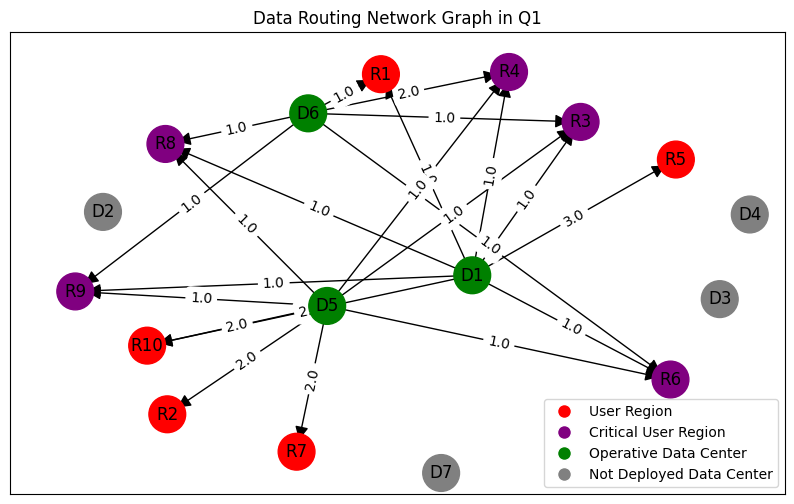

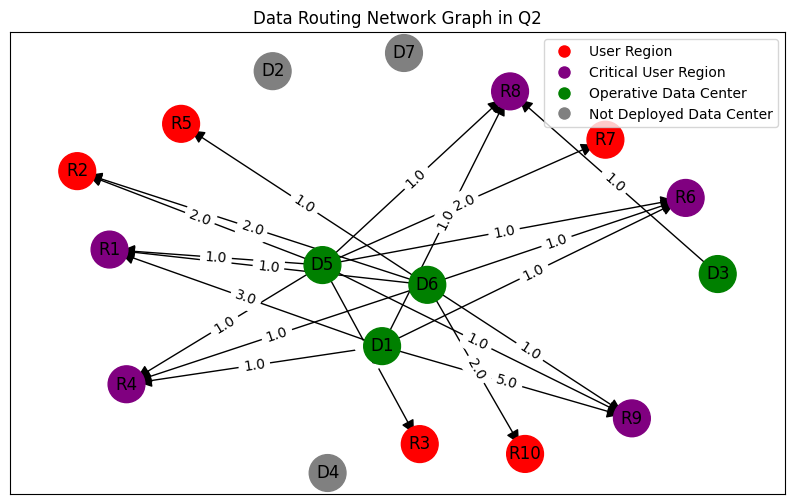

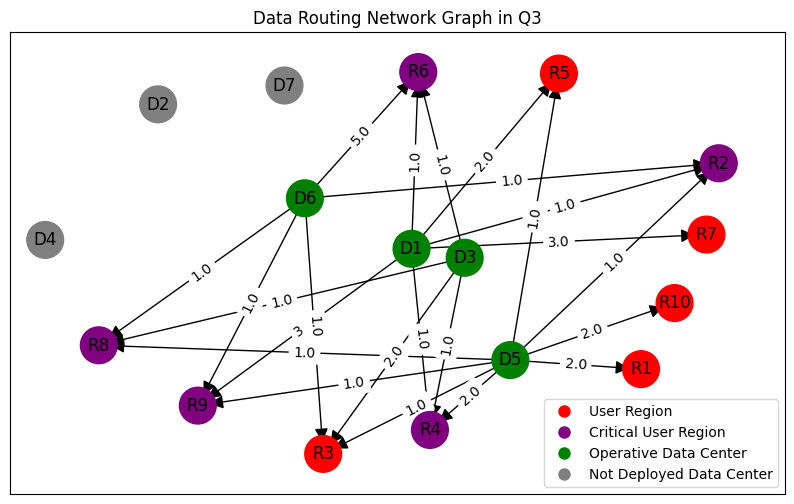

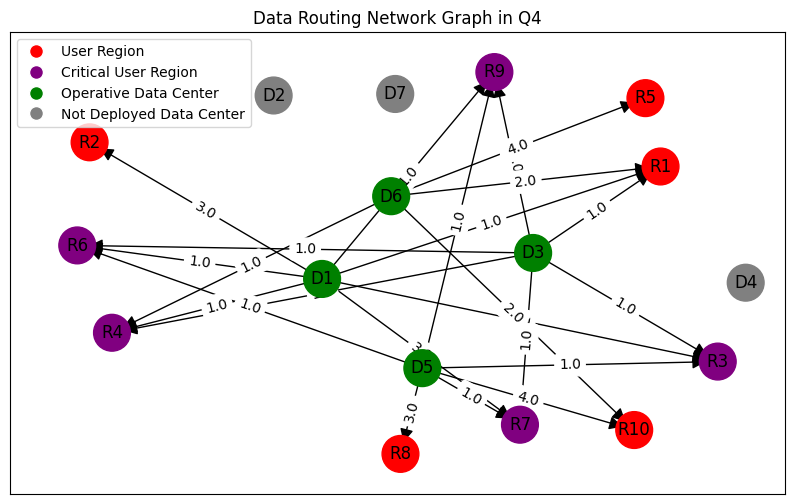

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

data_centers = list(model.D)  
regions = list(model.R) 
for q in model.Q:
    G = nx.DiGraph()

    # Add nodes 
    for d in data_centers:
        G.add_node(d, type = 'data', deployed = model.y[d, q].value)
    for r in regions:
        G.add_node(r, type = 'region', criticality = criticality[r, q])

    # Add edges 
    for d in data_centers:
        for r in regions:
            flow = model.x[r, d, q].value
            if flow > 0:  
                G.add_edge(d, r, weight=flow)

    plt.figure(figsize=(10, 6)) 
    pos = nx.spring_layout(G, k=2, scale=2)  

    node_colors = []
    for d in G.nodes():
        if G.nodes[d]['type'] == 'data':
            if G.nodes[d]['deployed'] == 0:
                node_colors.append('grey') 
            else:
                node_colors.append('green') 
        else:
            if G.nodes[d]['criticality'] == 1:
                node_colors.append('purple')
            else:
                node_colors.append('red')  

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)

    edge_labels = {(r, d): f"{G.edges[r, d]['weight']}" for r, d in G.edges}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    labels = {d: f"{d}" if d in data_centers else f"{d}" for d in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels)

    plt.title(f"Data Routing Network Graph in {q}")

    from matplotlib.lines import Line2D
    user_legend = Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='User Region')
    data_legend = Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Operative Data Center')
    data_not_legend = Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='Not Deployed Data Center')
    critical_user = Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Critical User Region')
    # Add the legend to the plot
    plt.legend(handles=[user_legend, critical_user, data_legend, data_not_legend])

    plt.show()



### Conclusions

Through the graph plots, we can clearly identify the optimization results for all time stamps and the optimal cases. This optimization model identifies the data centers to activate, balancing fixed setup costs and their handling capacities.

We could highlight how the model strategically allocates resources by concentrating data flows from fewer, high-capacity centers, e.g.: D3.
It is interesting how the solution is to use D1, D5, D6, and D3, and not activating other datacenters, despite the availability of data centers with greater capacities like D2, D4, or D7. This is because activating a data center incurs a **fixed setup cost**, and routing data through it incurs **energy costs**. Even though some data centers have greater capacities, they might also have higher fixed costs (i.e., D4 and D7) or energy costs (i.e., D2 and D4), making them less attractive to activate.

Based on the graphs, we can see how the **number of deployed data centers changes just from the 1st to the 2nd quarter**. This likely arises from differences in the aggregate request loads:

|Quarter | Aggregate Request Load|
|--------| ----------------------|
|Q1      | 26                    |
|Q2      | 31                    |
|Q3      | 34                    |
|Q4      | 34                    |

Therefore showing how, since each data center has a finite capacity for requests, if the total request load across all user regions exceeds the capacity of the active data centers, an additional center must be deployed to meet the demand.

If we go deeper, and check the **criticality importance**, we can see how criticality levels suggest higher importance in certain regions during Q2-Q4 compared to Q1. This leads to the activation of an additional data center to ensure capacity to handle requests with more priority and receiving data from at least 3 data centers. For example, regions with higher criticality:
- Q1: R3, R4, R6, R8, R9 with a request load sum of 13.
- Q2: R1, R4, R6, R8, R9 have critical requests summing 20.

It's also important to highlight how the **number of deployed data centers is always the same after the 2nd quarter, and the data centers do not change**, as the fixed setup costs applies only when a data center is activated, and it can remain active without incurring additional costs, what allows for maintaining a larger number of data centers, meeting demand without additional costs and not activating or deactivating any other centers. The results are clear and well plotted.


----------------

## Project II

### Introduction to the Non-Linear Optimization Project

Traffic Optimization in Urban Networks: Balancing Demand and Efficiency

The efficient management of urban traffic networks is a critical challenge for minimizing travel time, reducing congestion, and improving overall mobility. This project focuses on modeling and solving a Traffic Assignment Problem (TAP) using non-linear optimization techniques. We consider a simplified realistic city network with multiple routes connecting origin-destination pairs.

The project contains the following elements:

1. **Wardrop's Principle of Equilibrium**: A foundational concept in traffic modeling, ensuring that no user can reduce their travel time by switching routes.
2. **Non-linear travel cost functions**: These functions realistically capture the effects of congestion, where travel times increase as road capacities are approached.
3. **Capacitated arcs and budget constraints**: These constraints add complexity and realism, accounting for limited road capacities and investment limitations for infrastructure upgrades.

The primary objective of this project is to minimize total travel time across the network while meeting travel demand and exploring cost-effective upgrades to road capacities. This involves balancing short-term operational efficiency with long-term infrastructure investment strategies. 

Through this assignment, we want to show the application of advanced optimization techniques to urban planning, making the way for more effective and data-driven traffic management strategies.

In [36]:
# IMPORTS 
from pyomo.environ import *
import pandas as pd

### Data

* **Arcs**: These are the road segments or connections in the network. Each arc represents a specific link between nodes (intersections or destinations).

* **Routes**: Predefined paths that vehicles can take from an origin to a destination, consisting of specific arcs. 

* **Origin-Destination (OD) Pairs**: Represent the trips between specific origin and destination points

* **Demand**: Specifies the number of trips (vehicles) for each OD pair.

* **Arc Parameters**: For each arc, there are the following parameters:
    - **c0**: Free-flow travel time. Travel time if there is no congestion on the arc.
    - **b**: Congestion parameter affecting the growth of travel time with flow.
    - **n**: Exponent for congestion in the travel time function.
    - **k**: Capacity of the arc (maximum possible flow before congestion becomes significant)
    - **u_cost**: Upgrade cost for increasing the capacity of the arc.

* **Rout-to-Arc Mapping**: Specifies which arcs each routes uses.

* **OD-to-Route Mapping**: Maps OD paris to the routes available for those trips.

* **Budget for Upgrades**: Total available budget for upgrading arcs in the network.

* **Penalty Factor**: A weight applied to the unused capacity penalty in the objective function. This helps to balace travel time minimization and efficient resource usage. For an efficient use of arcs to upgrade. 

In [37]:
model = ConcreteModel()

arcs = ['a1', 'a2', 'a3', 'a4']
routes = ['r1', 'r2', 'r3', 'r4', 'r5']
od_pairs = ['w1', 'w2']

model.routes = Set(initialize=routes, doc = "Set of Routes")
model.arcs = Set(initialize=arcs, doc = "Set of Arcs")
model.od_pairs = Set(initialize=od_pairs, doc = "Set of Origin-Destination Pairs")

demand = {'w1': 4000, 'w2': 2500}
model.d = Param(model.od_pairs, initialize = demand)

arc_params = {
    'a1': {'c0': 5, 'b': 1, 'n': 4, 'k': 500, 'u_cost': 100},
    'a2': {'c0': 7, 'b': 1, 'n': 4, 'k': 400, 'u_cost': 200},
    'a3': {'c0': 10, 'b': 1, 'n': 4, 'k': 400, 'u_cost': 150},
    'a4': {'c0': 2, 'b': 1, 'n': 4, 'k': 500, 'u_cost': 50},
}
route_to_arc = {
    'r1': ['a1'],
    'r2': ['a2', 'a4'],
    'r3': ['a3', 'a4'],
    'r4': ['a2'],
    'r5': ['a3'],
}
od_to_routes = {
    'w1': ['r1', 'r2', 'r3'],
    'w2': ['r4', 'r5'],
}
budget = 300  # Budget for upgrades
alpha = 0.1  # Penalty factor for unused capacity

### Variables

* **Route Flow Variable** $h_r$: Represents the flow of traffic on each route in the Network.

* **Arc flow variable** $f_a$: Represents the total flow of traffic on each arc

* **Arc Upgrade Variable** $z_a$: Decision variables indicating the importance to upgrade an arc between (0, 1). 1 if the arc is a must to upgrade, 0 if we should not upgrade

In [38]:
model.h = Var(model.routes, within=NonNegativeReals)  # Flow on routes
model.f = Var(model.arcs, within=NonNegativeReals)   # Flow on arcs
model.z = Var(model.arcs, within=NonNegativeReals, bounds = (0, 1)) # Upgrade decision

-----------

### Constraints

* **Demand Satisfaction**: Ensures that the total flow on all routes for each origin-destination (OD) pair meets the demand.
$
\quad \sum_{r \in R_{w}} h_r = d_w \quad \forall w \in W
$

In [39]:
def demand_rule(model, w):
    return sum(model.h[r] for r in od_to_routes[w]) == model.d[w]

model.demand_constraints = Constraint(model.od_pairs, rule=demand_rule)

* **Arc flow conservation**: Ensures that the total flow on an arc matches the sum of flows on all routes that use that arc. 

$\quad \sum_{r \in R_{w}} \delta _{a,r} h_r = f_a \quad \forall a \in A$

$\quad $ Where $\delta _{a,r}$ is 1 if arc a is part of route r, and 0 otherwise.

In [40]:
def flow_conservation_rule(model, a):
    return sum(model.h[r] for r in model.routes if a in route_to_arc[r]) == model.f[a]

model.flow_constraints = Constraint(model.arcs, rule=flow_conservation_rule)

* **Capacity constraint**: Ensures that the low on each arc does not exceed its capacity.

$\quad f_a \le k_a \quad \forall a \in A$

In [41]:
def capacity_rule(model, a):
    return model.f[a] <= arc_params[a]['k']

model.capacity_constraints = Constraint(model.arcs, rule=capacity_rule)

* **Budge Constraint for Upgrades:** Ensures that the total cost of upgrades does not exceed the available budget.

$\quad \sum_{a \in A} ucost_a * z_a \le budget$

In [42]:
def budget_rule(model):
    return sum(arc_params[a]['u_cost'] * model.z[a] for a in model.arcs) <= budget

model.budget_constraint = Constraint(rule=budget_rule)

------------

### Model & Objective

$ \quad Z = \sum_{a \in A} \left( c_a^0 f_a + \frac{b_a}{n_a + 1} \left( \frac{f_a}{k_a} \right)^{n_a + 1} \right) + \alpha \sum_{a \in A} \left( k_a - f_a \right) z_a$

1. **Travel cost**: Represents total travel time across all arcs. $\sum_{a \in A} \left( c_a^0 f_a + \frac{b_a}{n_a + 1} \left( \frac{f_a}{k_a} \right)^{n_a + 1} \right)$
* It has a **Linear cost** based on the free-flow travel time.  $c_a^0 f_a$
* And a **non-linear congestion cost** that increases significantly as flow $f_a$ approaches the arc's capacity. $\frac{b_a}{n_a + 1} \left( \frac{f_a}{k_a} \right)^{n_a + 1}$

2. **Upgrade Penalty**: Penalizes unused capacity when an arc is upgraded. $\alpha \sum_{a \in A} \left( k_a - f_a \right) z_a$
* It has the variable z bounded between (0, 1) indicating how important an arc a should be upgraded.
*  $(k_a - f_a)$ represents the unused capcity on arc a. By multiplying this by z, the model penalizes unnecessary upgrades when an arc is underutilized. Where aplha controls the trade-off between minimizing travel cost and infrastructure upgrades.


We minimize total costs = travel time + Upgrade penalties.

In [43]:
def objective_rule(model):
    travel_cost = sum(
        arc_params[a]['c0'] * model.f[a] +
        (arc_params[a]['b'] / (arc_params[a]['n'] + 1)) *
        (model.f[a] / arc_params[a]['k'])**(arc_params[a]['n'] + 1)
        for a in model.arcs
    )

    upgrade_penalty = alpha * sum((arc_params[a]['k'] - model.f[a]) * model.z[a] for a in model.arcs)
    
    return travel_cost + upgrade_penalty

model.obj = Objective(rule=objective_rule, sense=minimize)

### Solve

In [44]:
solver = SolverFactory('ipopt')
results = solver.solve(model, tee = True)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       16
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:        8

Total number of variables............................:       13
                     variables with only lower bounds:        9
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number

### Results

In [45]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 9974.000813623878


Optimal total costs of 9974 units

In [46]:
# Display results
print("Route Flows:")
for r in routes:
    print(f"{r}: {model.h[r].value}")

print("\nArc Flows:")
for a in arcs:
    print(f"{a}: {model.f[a].value} (Upgraded: {model.z[a].value})")

Route Flows:
r1: 510.47262045802535
r2: 151.1407065737695
r3: 151.14075646168698
r4: 254.74050306566872
r5: 254.74043197679467

Arc Flows:
a1: 504.608044564869 (Upgraded: 0.8498391877724882)
a2: 402.66937405754595 (Upgraded: 0.023817243231586592)
a3: 402.6693523728253 (Upgraded: 0.04497003927609614)
a4: 302.2814630354565 (Upgraded: 0.0399268574822154)


#### **Route Flows**
1. **Route (r1):** 
   - The highest flow, with 510.47 units of traffic, is allocated to Route (r1), which uses Arc (a1). 
   - This suggests that (r1) is an efficient route with relatively low congestion, making it the most preferred for its origin-destination (OD) pair.

2. **Routes (r2) and (r3):** 
   - These routes carry nearly identical traffic flows of approximately 151.14 units each.
   - This balance indicates that the model is distributing traffic equitably between these routes, prevent overloading Arc (a2) or (a3).

3. **Routes (r4) and (r5):** 
   - Similar flows of around 254.74 units are allocated to these routes, which share the same OD pair.
   - The near-equal distribution suggests that both routes are similarly efficient.

---

#### **Arc Flows**
1. **Arc (a1):** 
   - The highest flow, with 504.61 units, occurs on Arc (a1), which corresponds to Route (r1).
   - The high utilization reflects its importance in the network, and it has been top prioritized to upgraded (z = 0.85).

2. **Arcs (a2) and (a3):** 
   - Both arcs experience flows of approximately 402.67 units, reflecting their shared responsibility for traffic from Routes (r2, r3, r4) and (r5).
   - Despite their significant usage, the upgrades for these arcs are minimal (z approx 0.02) to (0.04), showing that their capacities were sufficient respect to other arcs.

3. **Arc (a4):** 
   - Has 302.28 units of traffic and has received a not important to upgrade (z approx 0.04).
   - This moderate flow indicates it is less critical than other arcs but still contributes meaningfully to the network.

---

#### **Upgrade Decisions**
1. **Arc (a1):**
   - Very important to upgrade z = 0.85, reflecting a significant investment to increase capacity.
   - This decision aligns with its high traffic volume, as upgrading Arc (a1) reduces congestion on the busiest route.

2. **Arcs (a2), (a3), and (a4) (Minimally Upgraded):**
   - Each arc received minor upgrade importance z values between 0.02 and 0.04.
   - These upgrades indicate that these arcs operate near their capacity but we do not need to prioritize investments due to their capacity to controll traffic volumes or budget constraints.

---

#### **General Insights**

- The model has effectively balanced traffic across routes and arcs, avoiding severe congestion while respecting the capacity constraints of each arc.

- The optimization prioritized upgrading Arc (a1), as it serves the most significant traffic flow, while limiting upgrades on less-utilized arcs to stay in budget.

- The results reflect Wardrop’s Principle of Equilibrium—no route has unreasonably high or low flow, and all used routes offer comparable travel times.